In [1]:
# Following file was inspired by the following tutorial:
# https://colab.research.google.com/drive/1SiF0KZJp75rUeetKOWqpsA8clmHP6jMg?usp=sharing#scrollTo=d7utFz27cO9q

# And use this cource for explanation:
# https://bruno-yun.notion.site/The-Transformer-Model-for-NLG-c4413bd5a8044325a7658cb8ff5535f2
# https://web.stanford.edu/~jurafsky/slp3/9.pdf

In [2]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import math
from dataclasses import dataclass
from matplotlib import pyplot as plt
from graphviz import Digraph
import time
import os

In [3]:
from environnement.environnement1 import Environnement1 as env1
from environnement.environnement2Str import Environnement2 as env2Str
from environnement.environnement3Str import Environnement3 as env3Str
from environnement.environnement6Str import Environnement6 as env6Str

from environnement.small_loop import small_loop

from inter.interactions import Interaction as inter


Intro, bla bla bla

In [4]:
# Temporaire
VOCAB_SIZE = 2 # For now we are only using binary data (0, 1) later can be modify by 12
CONTEXT_LENGHT = 3 # And we are using a context of 3 bits (may be changed later)
device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu"

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads,
                 qkv_bias = False, device = 'cpu'):
        
        super().__init__()
        assert(d_out % num_heads == 0), "d_out should be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        # self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias) 
        # Don't use this because we want to have only one projection to optimize
        # To have only one projection we use the following line
        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias).to(device)

        self.dropout = nn.Dropout(dropout).to(device)
        self.out_proj = nn.Linear(d_out, d_out).to(device)
        # If we want to see past
        mask = torch.triu(torch.ones(context_length,context_length), diagonal=1).to(device)
        
        # if we want to see future
        # mask = torch.tril(torch.ones(context_length,context_length), diagonal=-1).to(device)
        
        # If we want to see all the context
        # mask = torch.zeros(context_length, context_length, device=device)
        self.register_buffer('mask', mask)
        
    def forward(self,x: torch.Tensor):
        queries: torch.Tensor
        keys: torch.Tensor
        values: torch.Tensor
        b, num_tokens, d_in = x.shape # b, num_token, d_in

        # self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Use one projection to get queries, keys and values
        # self.W_qkv(x) -> b, num_token, 3*d_out (is a tensor)
        # chunk(3, dim=-1) -> b, num_token, d_out we split the tensor in 3 parts
        queries, keys, values= self.W_qkv(x).chunk(3, dim=-1)
        
        # b, num_token, numheads, head_dim
        queries = queries.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        keys = keys.reshape(b,
                            num_tokens,
                            self.num_heads,
                            self.head_dim
                        ).transpose(1, 2)
        values = values.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        
        # b, num_heads, num_token, num_token
        attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        
        attn_scores = attn_scores.masked_fill(
            self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0).bool() == 1, 
            float('-inf')
        )

        attn_weights = nn.functional.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.einsum('bhqk, bhkd -> bhqd', 
                               attn_weights, 
                               values
                            ).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        
        
        return self.out_proj(context)
    

# Explain of class MultiHeadAttention
In transformers model, the **MultiHeadAttention** class is used to apply attention mechanisms to input sequences. Understanding how this class works requires first exploring **single-head** attention before generalizing to **multi-head attention**.

## Single-Head Attention
Attention in Transformers relies on measuring the similarity between tokens in a sequence. This measurement is performed using three distinct transformations:

- Query (Q): Represents the current token’s focus when comparing it to all other tokens.
- Key (K): Represents a token being compared to the query.
- Value (V): Represents the actual information to be aggregated based on attention scores.

These three representations are obtained by applying linear transformations to the input sequence. The transformed matrices allow us to compute the attention scores using the scaled dot-product attention formula:

$ 
score(x_i, x_j) = \frac{q_i \cdot k_j}{\sqrt{d_k}} 
$

Where $q_i$ is the query representation of token $i$, $k_j$ is the key representation of token $j$, and $d_k$ is the dimension of the key representation. 

In forward function is :
```python
attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
```

To prevent a token from attending to future tokens (as in autoregressive models like GPT), we apply a mask to the attention scores. This ensures that each token only attends to itself and previous tokens:

$
a_i = \sum_{j \leq i} \alpha_{ij}v_j
$

In forward function is :
```python
attn_scores = attn_scores.masked_fill(self.mask[:num_tokens, :num_tokens] == 0,
                                float('-inf'))
```

Once the attention scores are computed and masked, they are normalized using the softmax function to produce attention weights:

$
\alpha_{ij} = \frac{\exp(score(x_i,x_j))}{\sum_j \exp(score(x_i,x_j))}
$

In forward function is :
```python
attn_scores = nn.fonctional.softmax(attn_scores, dim=-1)
```

To prevent overfitting, a dropout layer is applied to the attention weights (self.dropout) before computing the context vector.

To compute the context vector, we multiply the attention weights by the Value (V) representations to obtain the context vector.

In forward function is :

```python
context = torch.einsum('bhqk, bhkd -> bhqd', attn_weights, values)
```

To resume we have done this :

![explain one head](./img/ExplainOneHeadAttention.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*

## Multi-Head Attention
Single-head attention allows each token to focus on others, but it has limitations: it can only capture one type of relationship at a time. Multi-head attention improves this by using multiple attention heads in parallel.
Instead of computing attention once, we split the input into multiple heads, each with a different representation of the sequence. This allows the model to capture diverse patterns.
All heads are concatenated and linearly transformed to produce the final output. This process is implemented in the **MultiHeadAttention**, is why we use self.head_dim or 'd' in code.

This figure resume compute with matrix :

![Compute](./img/ExplainCompute.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*


In [6]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        # TODO fct FFN we can change the number of layers
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"] // 2, bias=cfg["qkv_bias"]),
            nn.GELU(),
            nn.Linear(cfg["emb_dim"] // 2, cfg["emb_dim"], bias=cfg["qkv_bias"])
        )
        
    def forward(self,x):
        return self.layers(x)

# The FeedForward in transformer
The **FeedForward** class is used to apply a feedforward neural network to the output of the multi-head attention layer. The feedforward network consists of two linear transformations with a GELU (or RELU) activation function in between.

## GELU and RELU
GELU and RELU are activation functions used in neural networks after linear transformations. GELU is a smoother version of RELU that has been shown to improve performance in transformer models. 

The GELU function is defined as:

$
GELU(x) = 0.5x(1 + tanh(\sqrt{2/\pi}(x + 0.044715x^3)))
$

RELU is a simpler activation function that sets all negative values to zero:

$
RELU(x) = max(0, x)
$



In [7]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.norm1 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"],
            qkv_bias = cfg["qkv_bias"],
            device=cfg["device"]
        )
        self.ff = FeedForward(cfg).to(cfg["device"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.dropout = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
    def forward(self,x):
        # print("we are in one transformer block")
        # print(x.shape)
        # print(x)
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        # print("after att", x.shape)
        # print(x)
        x = self.dropout(x)

        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x+ shortcut
        # print(x.shape)
        # print(x)
        # print('end trs block')
        return x

# Explain of class TransformerBlock
The **TransformerBlock** class is the core building block of the transformer model. It consists of three main components: the **MultiHeadAttention**, the **FeedForward** layers and **LayerNorm**. The **MultiHeadAttention** layer is used to capture the relationships between tokens, while the **FeedForward** layer is used to apply non-linear transformations to the output of the attention layer. We use **LayerNorm** to normalize X and for normalize the output of the **FeedForward** layer.

![image.png](./img/ExplainArchiTrans.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*

In this figure we can see the Residual Stream. In the forward funciton it's name shortcut. It's a way to avoid the vanishing gradient problem. The output of the **FeedForward** layer is added to the input of the **MultiHeadAttention** layer. This allows the model to learn the difference between the input and output of the block, which helps to improve performance.




In [8]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        # Embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(cfg["device"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(cfg["device"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
        # Transformer Blocks
        self.trf_blocks = nn.ModuleList(
                [TransformerBlock(cfg) for _ in range(cfg["n_leayers"])]
            )
        
        # Normalization & Output layer
        self.final_norm = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["out_vocab_size"], bias=False).to(cfg["device"])
        
        # Weight tying: Share weights between embedding and output projection
        self.tok_emb.weight = self.out_head.weight
        
        # Initialize weights (If we need)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
        # Special initialization for transformer projection layers
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p,
                                    mean=0.0,
                                    std=0.02 / math.sqrt(2 * self.cfg["n_layers"]))
                
    def forward(self, x: torch.Tensor, return_full_sequence=False):
        b, seq_len = x.shape
        device = x.device
        # assert device != self.cfg['device'], "Input tensor device does not match model device"

        # print("in GPT, forward ",x)
        
        # Token & Positional Embeddings
        # (b, seq_len, emb_dim)
        tok_embeds = self.tok_emb(x)
        # print("tok_embeds ",tok_embeds)
        # (seq_len, emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        # print("pos_embeds ",pos_embeds)
        
        x = tok_embeds + pos_embeds
        # print("tok_embeds + pos_embeds ",x)
        x = self.drop_emb(x)
        # print("self.drop_emb(x) ",x)
        
        # Pass through Transformer Blocks
        deleteme = 0
        for block_ in self.trf_blocks:
            deleteme += 1
            x = block_(x)
            # print(f"block(x) n°{deleteme} : {x}")
        
        # Final normalization & output projection
        x = self.final_norm(x)
        # print("self.final_norm(x) ",x)
        logits = self.out_head(x)

        # print("logits ",logits)
        
        if not return_full_sequence:
            logits = logits[:, -1, :]  # (b, vocab_size)
        
        return logits

In [9]:
def evaluate_model(model, x_val, y_val):
    model.eval()
    with torch.no_grad():
        logits = model(x_val, False)
        loss = nn.functional.cross_entropy(logits, y_val)
    return loss.item()

def train_simple(model, optimizer, inputs, targets, n_iter, x_val=None, y_val=None, verbose=True):
    all_train_loss, all_val_loss = [], []
    for i in range(n_iter):
        logits = model(inputs, False)
        loss = nn.functional.cross_entropy(logits, targets)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 10 == 0:
            all_train_loss.append(loss.item())
            if x_val is not None:
                val_loss = evaluate_model(model, x_val, y_val)
                all_val_loss.append(val_loss)
                if verbose:
                    print(f'for {i} epochs, loss is {loss.item()} and val_loss is {val_loss}')
            else:
                if verbose:
                    print(f'for {i} epochs, loss is {loss.item()}')
                

    return all_train_loss, all_val_loss

def train_for_one_seq(model, optimizer, inputs, targets, n_iter, x_val=None, y_val=None, verbose=True):
    """ 
    Train the model for one sequence
    """
    all_train_loss, all_val_loss = [], []
    model.train()
    for i in range(n_iter):
        logits = model(inputs, False)
        loss = nn.functional.cross_entropy(logits, targets)
        predictions = torch.argmax(logits, dim=-1)
        for g in optimizer.param_groups:
            tmp = g['lr']
            break
        if predictions != targets:
            for g in optimizer.param_groups:
                g['lr'] /= 10
            

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        for g in optimizer.param_groups:
            g['lr'] = tmp

        # if i % 10 == 0:
        all_train_loss.append(loss.item())
        if x_val is not None:
            val_loss = evaluate_model(model, x_val, y_val)
            all_val_loss.append(val_loss)
            if verbose:
                print(f'for {i} epochs, loss is {loss.item()} and val_loss is {val_loss}')
        else:
            if verbose:
                print(f'for {i} epochs, loss is {loss.item()}')
                
    if len(all_val_loss) == 0:
        all_val_loss = [20]

    if len(all_train_loss) == 0:
        all_train_loss = [20]
    return all_train_loss, all_val_loss

In [10]:
def generate_sequence(model, context, n_tokens):
    with torch.no_grad():
        for _ in range(n_tokens):
            logits = model(context, False)
            probas = torch.softmax(logits, dim=-1)
            next_token = torch.argmax(probas, dim=-1).unsqueeze(0)
            context = torch.cat([context, next_token], dim=-1).to(device)
    return context

CONFIG_TEST = {
    "vocab_size": 2,
    "context_length": 15,
    "emb_dim": 16,
    "n_heads": 4,
    "n_leayers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "device": device,
    "out_vocab_size": 2
}

model_test = GPTModel(CONFIG_TEST)
generate_sequence(model_test, torch.randint(0, CONFIG_TEST["vocab_size"], (1, 3)).to(CONFIG_TEST["device"]), 10)


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
GPT_CONFIG_124M_small = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_leayers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "device": device
}

OUR_CONFIG = {
    "vocab_size": VOCAB_SIZE,
    "context_length": CONTEXT_LENGHT,
    "emb_dim": 16,
    "n_heads": 4,
    "n_leayers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "device": device
}

In [12]:
def all_possible(n, k):
    """
    Generate all possible combination of n elements taken k by k
    """
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c


In [13]:
def plot_model(gpt, token_to = None, graph = True):
    """
    Plot the transition graph of the GPT model
    """
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.cfg["vocab_size"], gpt.cfg["context_length"]):
        
        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...]
        x = x.to(gpt.cfg["device"])
        # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x, False) # forward the gpt neural net

        # print('logits :', logits)
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        if token_to:
            print(f"input {token_to(xi)} ---> {y}")
        else:
            print(f"input {xi} ---> {y}")

        if graph:
            # also build up the transition graph for plotting later
            current_node_signature = "".join(str(d) for d in xi)
            dot.node(current_node_signature)
            # input("Press Enter to continue...")

            for t in range(gpt.cfg["vocab_size"]):
                next_node = xi[1:] + [t] # crop the context and append the next character
                next_node_signature = "".join(str(d) for d in next_node)
                p = y[t]

                label=f"{t}({p*100:.0f}%)"
                dot.edge(current_node_signature, next_node_signature, label=label)
    
    return dot

# gpt = GPTModel(OUR_CONFIG)
# plot_model(gpt)    

In [14]:
CONFIG_TRAIN = {
    "vocab_size": 2,
    "context_length": 3,
    "emb_dim": 16,
    "n_heads": 4,
    "n_leayers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "device": device
}

# inputs = torch.tensor([[0, 1, 1],
#                        [1, 0, 0],
#                        [1, 1, 0],
#                        [0, 0, 1]]).to(CONFIG_TRAIN["device"])

# targets = torch.tensor([[1, 1, 1],
#                         [0, 0, 1],
#                         [1, 0, 1],
#                         [0, 1, 0]]).to(CONFIG_TRAIN["device"])


# probas = torch.softmax(model_test(inputs), dim=-1)

# print(probas)

# output = torch.argmax(probas, dim=-1)

# print(output)


# text_prob1= probas[0, targets[0]]
# print("proba text1", text_prob1)
# print("proba text1 - what we obtained", probas[0, output[0].flatten()])


In [15]:
# let's train our baby GPT on this sequence
seq = list(map(int, "111101111011110"))
print('seq', seq)

# convert the sequence to a tensor holding all the individual examples in that sequence
X, Y = [], []
# iterate over the sequence and grab every consecutive 3 bits
# the correct label for what's next is the next bit at each position
# for i in range(len(seq) - 3):
#     X.append(seq[i:i+3])
#     Y.append(seq[i+3])
#     print(f"example {i+1:2d}: {X[-1]} --> {Y[-1]}")
# X = torch.tensor(X, dtype=torch.long).to(CONFIG_TRAIN["device"])
# Y = torch.tensor(Y, dtype=torch.long).to(CONFIG_TRAIN["device"])
# print(X.shape, Y.shape)
# torch.manual_seed(1337)


# config = GPTConfig(
#     block_size = 3,
#     vocab_size = 2,
#     n_layer = 4,
#     n_head = 4,
#     n_embd = 16,
#     bias = False,
# )
# gpt = GPT(config)

# optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

# for i in range(50):
#     logits = gpt(X)
#     loss = nn.functional.cross_entropy(logits, Y)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(i, loss.item())


# print("Training data sequence, as a reminder:", seq)
# plot_model()



CONFIG_TRAIN = {
    "vocab_size": 2,
    "context_length": 3,
    "emb_dim": 16,
    "n_heads": 4,
    "n_leayers": 4,
    "drop_rate": 0.000,
    "qkv_bias": False,
    "device": device
}
# model = GPTModel(CONFIG_TRAIN)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-1)

# for i in range(10):
#     logits = model(X, False)
#     print("logits", logits)
#     loss = nn.functional.cross_entropy(logits, Y)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(i, loss.item())


# print("Training data sequence, as a reminder:", seq)
# plot_model(model)

seq [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]


In [16]:
# model = GPTModel(CONFIG_TRAIN)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-1)

# inputs = torch.tensor([[0, 1, 1, 1],
#                        [1, 0, 0, 1],
#                        [1, 1, 0, 0]])

# targets = torch.tensor([1, 1, 1])

# # train the GPT for some number of iterations
# for i in range(3):

#     logits = model(inputs, False)
#     print(logits)
#     loss = nn.functional.cross_entropy(logits, targets)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(i, loss.item())

In [17]:
# Environment 1
# Action 0 => 0
# Action 1 => 1

# history_action = []
# hystory_fb = []
# history_pred = []

# env = env1()
# model = GPTModel(
#     {
#         "vocab_size": 2,
#         "context_length": 1,
#         "emb_dim": 16,
#         "n_heads": 4,
#         "n_leayers": 4,
#         "drop_rate": 0.1,
#         "qkv_bias": False,
#         "device": device
#     }
# )

# action = 0
# inputs = torch.tensor([[action]]).t
# targets = torch.tensor([0])

# for i in range(100):
#     action = i%2
#     history_action.append(action)
#     feedback = env.outcome(action)
#     hystory_fb.append(feedback)

#     inputs = torch.tensor([[action]]).to(device)
#     targets = torch.tensor([feedback]).to(device)
#     logits = model(inputs, False)
#     print(logits)
#     history_pred.append(torch.argmax(logits).item())
#     loss = nn.functional.cross_entropy(logits, targets)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(i, loss.item())
    
# print(history_action)
# print(hystory_fb)
# print(history_pred)


In [18]:
def addapt_seq(seq, context_length):
    X, Y = [], []
    for i in range(len(seq) - context_length):
        X.append(seq[i:i+context_length])
        Y.append(seq[i+context_length])
    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)


In [19]:
# # Environment 2, goal is predict outcome with action.
# # X are all action
# # For each X we associate Y, the outcome of the action
# # X is context lenght action

# history_action = []
# hystory_fb = []
# history_pred = []

# env = env2Str()

# action = 0
# inputs = torch.tensor([[action]])
# targets = torch.tensor([0])

# for i in range(20):
#     action = torch.randint(0, 2, (1,)).item()
#     history_action.append(action)
#     feedback = env.outcome(action)
#     hystory_fb.append(feedback)

# CONTEXT_LENGHT = 4
# model = GPTModel(
#     {
#         "vocab_size": 2,
#         "context_length": CONTEXT_LENGHT,
#         "emb_dim": 16,
#         "n_heads": 4,
#         "n_leayers": 4,
#         "drop_rate": 0.1,
#         "qkv_bias": False,
#         "device": device
#     }
# )


# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-1)

# inputs, targets = addapt_seq(history_action, CONTEXT_LENGHT)
# # inputs, targets = addapt_seq(list(map(int, "111101111011110")), CONTEXT_LENGHT)
# inputs = inputs.to(device)
# targets = torch.tensor(hystory_fb[CONTEXT_LENGHT-1:-1]).to(device)

# print("inputs")
# print(inputs)
# print(targets)

# for j in range(100):
#     logits = model(inputs, False)
#     loss = nn.functional.cross_entropy(logits, targets)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(j, loss.item())

# history_pred.append(torch.argmax(logits).item())
    
# print(history_action)
# print(hystory_fb)
# print(history_pred)

# plot_model(model)



In [20]:
def interaction_to_token(interaction, base=2):
    return [int(f"{a}{b}", base) for a, b in interaction]
    
def token_to_interaction(token, base=2):
    return [(i // base, i % base) for i in token]

x = interaction_to_token([(0, 1), (1, 0), (1, 1), (0, 0)])
print(x)
y = token_to_interaction(x)
print(y)

x = interaction_to_token([(0, 3), (3, 0), (2, 1), (2, 0)], 4)
print(x)
y = token_to_interaction(x, 4)
print(y)

[1, 2, 3, 0]
[(0, 1), (1, 0), (1, 1), (0, 0)]
[3, 12, 9, 8]
[(0, 3), (3, 0), (2, 1), (2, 0)]


In [21]:
# # 
# history = []
# history_action = []
# hystory_fb = []
# history_pred = []
# context_lenght = 2

# env = env3()

# action = 0
# inputs = torch.tensor([[action]])
# targets = torch.tensor([0])

# for i in range(1000):
#     action = torch.randint(0, 2, (1,)).item()
#     feedback = env.outcome(action)

#     history_action.append(action)
#     hystory_fb.append(feedback)

#     history.append((action, feedback))

# history_token = interaction_to_token(history)
# voc = 4
# inputs, targets = addapt_seq(history_token, context_lenght)

# inputs = inputs.to(device)
# targets = targets.to(device)

# mymodel = GPTModel(
#     {
#         "vocab_size": voc,
#         "context_length": context_lenght,
#         "emb_dim": 16,
#         "n_heads": 4,
#         "n_leayers": 4,
#         "drop_rate": 0.1,
#         "qkv_bias": False,
#         "device" : device
#     }
# )

# for j in range(100):
#     logits = mymodel(inputs, False)
#     loss = nn.functional.cross_entropy(logits, targets)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     print(j, loss.item())

# plot_model(mymodel, None, False)

In [22]:
# x = mymodel(torch.tensor([[1, 1]]).to(device), False)
# probs = nn.functional.softmax(x, dim=-1)
# print(probs)

In [23]:
def create_all_words(valence:dict, nb_diff:int):
    vocab = []
    for k in valence.keys():
        for i in range(0, nb_diff + 1):
            l, r = k
            vocab.append(str(str(l) + str(r) + str(i)))
    return vocab

valence = {
    (0, 0) : 0,
    (0, 1) : -10,
    (1, 0) : 10,
    (1, 1) : 0
}

all_words = create_all_words(valence, 80)
vocab = {token:integer for integer, token in enumerate(all_words)}

def create_all_words_enumerate(valence:dict, nb_valance_possible:int):
    all_words = create_all_words(valence, nb_valance_possible)
    return {token:integer for integer, token in enumerate(all_words)}
print(vocab)

{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '0010': 10, '0011': 11, '0012': 12, '0013': 13, '0014': 14, '0015': 15, '0016': 16, '0017': 17, '0018': 18, '0019': 19, '0020': 20, '0021': 21, '0022': 22, '0023': 23, '0024': 24, '0025': 25, '0026': 26, '0027': 27, '0028': 28, '0029': 29, '0030': 30, '0031': 31, '0032': 32, '0033': 33, '0034': 34, '0035': 35, '0036': 36, '0037': 37, '0038': 38, '0039': 39, '0040': 40, '0041': 41, '0042': 42, '0043': 43, '0044': 44, '0045': 45, '0046': 46, '0047': 47, '0048': 48, '0049': 49, '0050': 50, '0051': 51, '0052': 52, '0053': 53, '0054': 54, '0055': 55, '0056': 56, '0057': 57, '0058': 58, '0059': 59, '0060': 60, '0061': 61, '0062': 62, '0063': 63, '0064': 64, '0065': 65, '0066': 66, '0067': 67, '0068': 68, '0069': 69, '0070': 70, '0071': 71, '0072': 72, '0073': 73, '0074': 74, '0075': 75, '0076': 76, '0077': 77, '0078': 78, '0079': 79, '0080': 80, '010': 81, '011': 82, '012': 83, '013': 84, '01

In [24]:
class SimpleTokenizerV1:
    
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
        
    def encode(self, text):
        """

        """
        if type(text) == list:
            return [self.str_to_int[word] for word in text]
        else:
            return self.str_to_int[text]
    
    def decode(self, ids):
        if type(ids) == list:
            return [self.int_to_str[id] for id in ids]
        else:
            return self.int_to_str[ids]
    
# tokenizer = SimpleTokenizerV1(vocab)

# print(tokenizer.encode(["011", "102", "113"]))

In [25]:
list_tempo = [1, 2, 3, 4, 5, 6]
print(list_tempo[2: 7])

[3, 4, 5, 6]


In [26]:
def get_valance_in_seq(seq:list, valence:dict):
    """
    Sum all valences in a sequence
    Exemple:
    seq = [(1, 0), (0, 1), (0, 1)]
    valence = {(0, 0) : 0, (0, 1) : -10, (1, 0) : 10, (1, 1) : 0}
    get_valance_in_seq(seq, valence) => -10
    """
    return sum(valence.get(tuple(pair), None) for pair in seq)

def valance_seq(valence, seq, len_seq):
    """
    Create a list of valences for all sequences of size len_seq in seq
    Exemple:
    seq = [(1, 0), (0, 1), (0, 1), (0, 1)]
    valence = {(0, 0) : 0, (0, 1) : -10, (1, 0) : 10, (1, 1) : 0}
    len_seq = 2
    valance_seq(valence, seq, len_seq) => [0, -10, -10]
    """
    X = []
    for i in range(0, len(seq) - len_seq + 1):
        X.append(get_valance_in_seq(seq[i: i+len_seq], valence))
    return X

def inter_valance_by_nb_seq(valence:dict, seq:list, n_seq:int):
    """
    Create "word" for each interaction. A "word" is interaction + valence of the next n_seq interactions
    Exemple:
    valence = {(0, 0) : 0, (0, 1) : -10, (1, 0) : 10, (1, 1) : 0}
    sed = [(1, 0), (1, 0), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (0, 1), (0, 1)]
    n_seq = 2
    inter_valance_by_nb_seq(valence, seq, n_seq) => ['1020', '100', '0120', '0140', '1040', '1020', '100']

    This word can be tokenize
    """
    seq_valance = []
    valance_by_seq = valance_seq(valence, seq[1:], n_seq)
    ajout  = n_seq * abs(min(valence.values()))
    for i, val in enumerate(valance_by_seq):
        l, r = seq[i]
        seq_valance.append(str(l) + str(r) + str(val + ajout))
    # seq_valance.pop()
    return seq_valance

    

valence = {
    (0, 0) : 0,
    (0, 1) : -10,
    (1, 0) : 10,
    (1, 1) : 0
}

# print("teste :", valance_seq(valence, [(1, 0), (1, 0), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (0, 1), (0, 1)], 2))

# inputs = inter_valance_by_nb_seq(valence, 
#                     [(1, 0), (1, 0), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (0, 1), (0, 1)], 2)
# print(inputs)



In [27]:
min(valence.values())
    

-10

In [28]:
# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#     logits = model(input_batch)
#     return torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())

# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     model.eval()
#     with torch.no_grad():
#         train_loss = calc_loss_batch(train_loader, model, device)
#         val_loss = calc_loss_batch(val_loader, model, device, num_batches=eval_iter)
#     model.train()
#     return train_loss, val_loss

# def train_batch(model,
#                train_loader,
#                val_lodaer,
#                optimizer, 
#                device,
#                num_epochs,
#                eval_freq = 10):

#     train_losses, val_losses, track_tokens_seen = [], [], []
#     token_seen, global_step = 0, -1

#     for epoch in range(num_epochs):
#         model.train()

#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad()
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()
#             optimizer.step()
#             token_seen += input_batch.numel()
#             global_step +=1 #nombre de batch vu

#             if global_step % 10 == 0:
#                 train_loss, val_loss = evaluate_model(model, train_loader, val_lodaer, device, eval_freq)            
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(token_seen)
#                 print("Epoch", epoch+1, "global step", global_step, "Train loss", train_loss,
#                       "Val loss", val_loss)

#     return train_losses, val_losses, track_tokens_seen


In [29]:
# # 
# history = []
# history_action = []
# hystory_fb = []
# history_pred = []
# context_lenght = 30
# nb_seq_valance = 3

# env = env2()

# action = 0
# inputs = torch.tensor([[action]])
# targets = torch.tensor([0])

# valence = {
#     (0, 0) : 0,
#     (0, 1) : -1,
#     (1, 0) : 1,
#     (1, 1) : 0
# }


# for i in range(100):
#     action = torch.randint(0, 2, (1,)).item()
#     feedback = env.outcome(action)
#     history_action.append(action)
#     hystory_fb.append(feedback)
#     history.append((action, feedback))


# nb_valence_possible = nb_seq_valance * (abs(min(valence.values())) + abs(max(valence.values())))
# print('nb_valence_possible')
# print(nb_valence_possible)
                                                                         

# all_world_enum = create_all_words_enumerate(valence=valence,
#             nb_valance_possible=nb_valence_possible)

# tokenizer = SimpleTokenizerV1(all_world_enum)
# voc = len(all_world_enum)
# print('voc size')
# print(voc)

# inputs = inter_valance_by_nb_seq(valence, history, nb_seq_valance)
# inputs = tokenizer.encode(inputs)

# inputs, targets = addapt_seq(inputs, context_lenght)
# inputs = inputs.to(device)
# targets = targets.to(device)

# print('inputs done :')
# print(inputs)
# print("target done :")
# print(targets)


# mymodel = GPTModel({
#         "vocab_size": voc,
#         "context_length": context_lenght,
#         "emb_dim": 320,
#         "n_heads": 4,
#         "n_leayers": 4,
#         "drop_rate": 0.1,
#         "qkv_bias": False,
#         "device": device
#     })


# optimizer = torch.optim.AdamW(mymodel.parameters(), lr=1e-2, weight_decay=1e-2)
# mymodel.train()
# # train_simple(mymodel, optimizer, inputs, targets, 100)


In [30]:
def see_proba(probs, tokenizer = None):
    plt.bar(range(len(probs)), probs)
    plt.text(probs.index(max(probs)), max(probs), str(max(probs)), ha='center')
    if tokenizer:
        plt.text(probs.index(max(probs)), max(probs) + 0.5, tokenizer.decode(max(probs)), ha='center')
    plt.show()

In [31]:
# seq = ['014']
# mymodel.eval()
# x = mymodel(torch.tensor([tokenizer.encode(seq)]).to(device), False)
# probs = nn.functional.softmax(x, dim=-1)
# predi = torch.argmax(probs)

# see_proba(probs[0].tolist(), None)
# print(tokenizer.decode([predi.item()]))
# print(f'for seq {str(seq)} the next token is {tokenizer.decode([predi.item()])}')

# seq_gen = generate_sequence(mymodel, torch.tensor([tokenizer.encode(seq)]).to(device), context_lenght)

# print(tokenizer.decode(seq_gen[0].tolist()))


In [32]:
# Input = ActionOutcomeAction
# Output = ActionOutcomeAction**Outcome**
# Word is Action and Outcome

# All words
def create_all_words_action_outcome(action:list, feedback:list):
    return action + feedback

def create_all_words_action_outcome_enumerate(action:list, feedback:list):
    all_words = create_all_words_action_outcome(action, feedback)
    return {word:integer for integer, word in enumerate(all_words)}

# create_all_words_action_outcome([0, 1, 2, 3], ['A', 'B'])
# create_all_words_action_outcome_enumerate([0, 1, 2, 3], ['A', 'B'])
# tokenizer_act_ff = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(['0', '1', '2', '3'], ['A', 'B']))
# tempo = tokenizer_act_ff.encode(['0', 'A', '1', 'B'])
# print(tempo)
# print(tokenizer_act_ff.decode(tempo))

In [33]:
My_list = [[0, 1, 2, 3], ['A', 'B']]
My_list[0]

My_list[0] = [0, 3, 2, 3]
print(My_list)

[[0, 3, 2, 3], ['A', 'B']]


In [34]:
# [(0, 'x'), (1, 'x'), (1, 'x'), (1, 'x'), (1, 'x'), (1, 'x'), (1, 'x'), (1, 'x')]
# [[0], [0, x, 1], []
def inter_action_and_feedback_size(history:list, size:int):
    """
    Transform history into input and target.
    history is a sequence of action and feedback.
    We want to have all sequence of size size, associate with the feedback of the last action (targets).
    Exemple:
    history = [('0', 'x'), ('1', 'y'), ('0', 'x'), ('1', 'y'), ('0', 'x'), ('1', 'y'), ('0', 'x')]
    size = 5
    inter_action_and_feedback_size(history, size) => 
    inputs = [['0', 'x', '1', 'y', '0'], 
    ['1', 'y', '0', 'x', '1'],
    ['0', 'x', '1', 'y', '0'],
    ['1', 'y', '0', 'x', '1'],
    ['0', 'x', '1', 'y', '0']]

    targets = ['x', 'y', 'x', 'y', 'x']

    """
    inputs, targets = [], []
    for act, ff in history:
        if inputs:
            temp = inputs[-1][-int(size - 2):] + [targets[-1], act]
            inputs.append(temp)
        else:
            inputs.append([act])
        targets.append(ff)
    return inputs[size - 1:], targets[size- 1:]

inputs, targets = inter_action_and_feedback_size([('0', 'x'), ('1', 'y'), ('0', 'x')], 5)
print(inputs)
print(targets)

# print(create_all_words_action_outcome_enumerate(['0', '1'], ['x', 'y']))
# tokenizer = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(['0', '1'], ['x', 'y']))
# print(targets)
# print(tokenizer.encode(targets))

# print(inputs)
# for i, one_input in enumerate(inputs):
#     inputs[i] = tokenizer.encode(inputs[i])

# print(inputs)

[]
[]


In [35]:
def create_all_words_by_env(env):
    vocab = []
    action = env.get_actions()
    feedback = env.get_outcomes()
    for act in action:
        for ff in feedback:
            vocab.append(str(act) + str(ff))
    return vocab

def create_all_words_by_env_enumerate(env):
    all_words = create_all_words_by_env(env)
    return {word:integer for integer, word in enumerate(all_words)}

env = env2Str()
tokenizer = create_all_words_by_env_enumerate(env)
print(tokenizer)


{'ax': 0, 'ay': 1, 'bx': 2, 'by': 3}


[('a', 'x'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a

for 0 epochs, loss is 1.4193642139434814 and val_loss is 1.2963099479675293
for 10 epochs, loss is 0.7694078683853149 and val_loss is 0.7486584782600403
for 20 epochs, loss is 0.7001091241836548 and val_loss is 0.6969918012619019
for 30 epochs, loss is 0.6986018419265747 and val_loss is 0.6972209215164185
for 40 epochs, loss is 0.6944737434387207 and val_loss is 0.6913231015205383
for 50 epochs, loss is 0.6927670240402222 and val_loss is 0.6907631158828735
for 60 epochs, loss is 0.6917691230773926 and val_loss is 0.6895061135292053
for 70 epochs, loss is 0.6910179257392883 and val_loss is 0.6888019442558289
for 80 epochs, loss is 0.6903334856033325 and val_loss is 0.6884320974349976
for 90 epochs, loss is 0.6895778775215149 and val_loss is 0.6877660751342773
for 100 epochs, loss is 0.688504159450531 and val_loss is 0.6869984269142151
for 110 epochs, loss is 0.685599148273468 and val_loss is 0.6850634217262268
for 120 epochs, loss is 0.6914135217666626 and val_loss is 0.6903521418571472

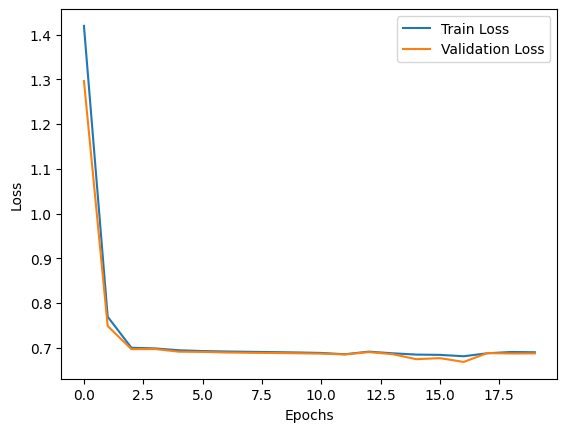

In [36]:
history = []
historyTest = []
context_lenght = 21
nb_seq_valance = 3

env = env3Str()

action = 0
inputs = torch.tensor([[action]])
targets = torch.tensor([0])

valence = {
    ('a', 'x') : 0,
    ('a', 'y') : -1,
    ('b', 'x') : 1,
    ('b', 'y') : 0
}

# train
for i in range(100):
    action = np.random.choice(['a', 'b'])
    feedback = env.outcome(action)
    history.append((str(action), str(feedback)))

# test
for i in range(100):
    action = np.random.choice(['a', 'b'])
    feedback = env.outcome(action)
    historyTest.append((str(action), str(feedback)))

print(history)
tmpInput, tmpTarget = inter_action_and_feedback_size(history, context_lenght)

tokenizer = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(['a', 'b', 'x', 'y'], []))

inputs = []
for i, one_input in enumerate(tmpInput):
    inputs.append(tokenizer.encode(one_input))
targets = tokenizer.encode(tmpTarget)

inputs= torch.tensor(inputs, dtype=torch.long).to(device)
targets = torch.tensor(targets, dtype=torch.long).to(device)

tmpXtest, tmpYtest = inter_action_and_feedback_size(historyTest, context_lenght)

x_test = []
for i, one_input in enumerate(tmpXtest):
    x_test.append(tokenizer.encode(one_input))
y_test = tokenizer.encode(tmpYtest)

x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

mymodel = GPTModel({
        "vocab_size": len(['a', 'b', 'x', 'y']),
        "context_length": context_lenght,
        "emb_dim": 16,
        "n_heads": 4,
        "n_leayers": 4,
        "drop_rate": 0.1,
        "qkv_bias": False,
        "device": device,
        "out_vocab_size": len(['a', 'b', 'x', 'y'])
    })

optimizer = torch.optim.AdamW(mymodel.parameters(), lr=1e-2, weight_decay=1e-2)

train_loss, val_loss = train_simple(mymodel, optimizer, inputs, targets, 200, x_test, y_test)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




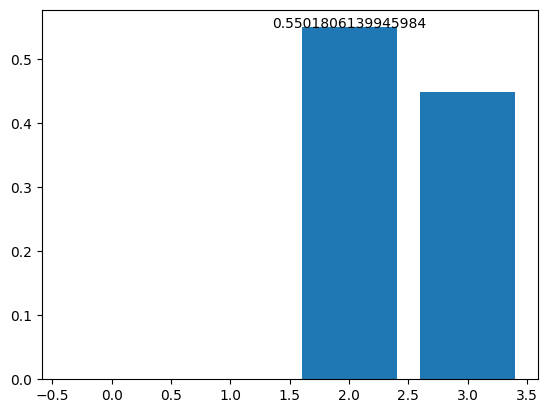

for seq tensor([[1, 2, 1, 2, 1, 2, 0, 3, 0, 2, 0, 2, 1, 3, 0, 2, 0, 2, 1, 2, 0]]) the next token is ['x']


In [37]:
# test model 

seq =torch.tensor([[1, 2, 1, 2, 1, 2, 0, 3, 0, 2, 0, 2, 1, 3, 0, 2, 0, 2, 1, 2, 0]]).to(device)
mymodel.eval()
x = mymodel(seq, False)
probs = nn.functional.softmax(x, dim=-1)
predi = torch.argmax(probs)
see_proba(probs[0].tolist(), None)
print(f'for seq {str(seq)} the next token is {tokenizer.decode([predi.item()])}')

In [38]:
def accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        logits = model(x, False)
        # loss = nn.functional.cross_entropy(logits, y)
        pred = torch.argmax(logits, dim=-1)
        acc = (pred == y).float().mean()
    return acc.item()

[('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('b', 'y'), ('a', 'y'), ('a', 'x'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a', 'y'), ('a', 'x'), ('b', 'y'), ('b', 'x'), ('b', 'x'), ('b', 'x'), ('a

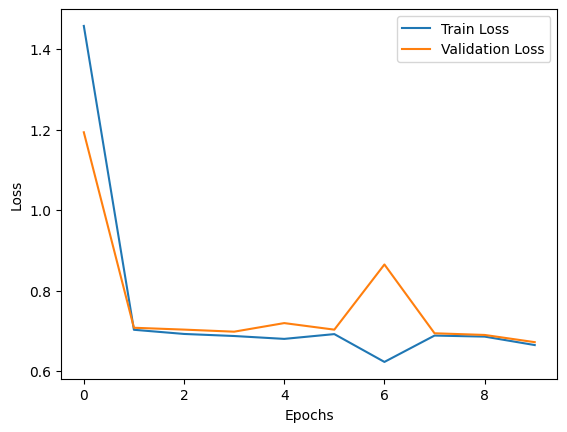

In [39]:
history = []
historyTest = []
context_lenght = 21
nb_seq_valance = 3

env = env3Str()

action = 0
inputs = torch.tensor([[action]])
targets = torch.tensor([0])

valence = {
    ('a', 'x') : 0,
    ('a', 'y') : -1,
    ('b', 'x') : 1,
    ('b', 'y') : 0
}

# test
for i in range(1000):
    action = np.random.choice(['a', 'b'])
    feedback = env.outcome(action)
    historyTest.append((str(action), str(feedback)))

# TODO lunch test to see evolued accuracy and loss in function of the number of training
# train
for i in range(100):
    action = np.random.choice(['a', 'b'])
    feedback = env.outcome(action)
    history.append((str(action), str(feedback)))


print(history)
tmpInput, tmpTarget = inter_action_and_feedback_size(history, context_lenght)

tokenizer = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(['a', 'b', 'x', 'y'], []))

inputs = []
for i, one_input in enumerate(tmpInput):
    inputs.append(tokenizer.encode(one_input))
targets = tokenizer.encode(tmpTarget)

inputs= torch.tensor(inputs, dtype=torch.long).to(device)
targets = torch.tensor(targets, dtype=torch.long).to(device)

tmpXtest, tmpYtest = inter_action_and_feedback_size(historyTest, context_lenght)

x_test = []
for i, one_input in enumerate(tmpXtest):
    x_test.append(tokenizer.encode(one_input))
y_test = tokenizer.encode(tmpYtest)

x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

mymodel = GPTModel({
        "vocab_size": len(['a', 'b', 'x', 'y']),
        "context_length": context_lenght,
        "emb_dim": 16 * 2,
        "n_heads": 4,
        "n_leayers": 4,
        "drop_rate": 0.2,
        "qkv_bias": False,
        "device": device,
        "out_vocab_size": len(['a', 'b', 'x', 'y'])
    })

optimizer = torch.optim.AdamW(mymodel.parameters(), lr=1e-2, weight_decay=1e-2)

train_loss, val_loss = train_simple(mymodel, optimizer, inputs, targets, 100, x_test, y_test)

print(accuracy(mymodel, x_test, y_test))

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [40]:
def save_plot_loss(train_loss, val_loss, path:str="img_loss", title:str=""):
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # if title == "" title = 'loss' + nb img save
    if not os.path.exists(path):
        os.makedirs(path)
    
    if title == "":
        title = 'loss' + str(len(os.listdir(path)))
    plt.savefig(path + '/' + title + '.png')
    plt.close()


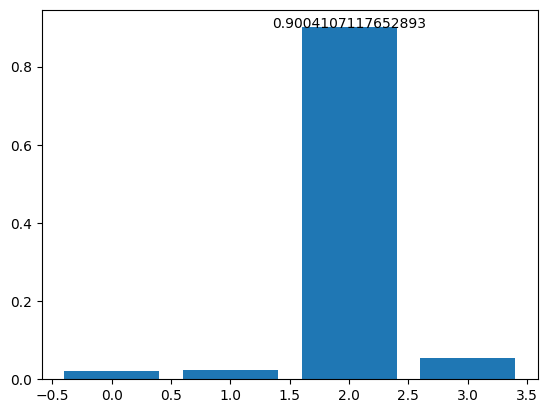

for seq tensor([[1, 2, 0, 3, 0, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1]]) the next token is ['x']


In [41]:
# test model 
# seq =torch.tensor([tokenizer.encode(['b', 'x', 'a', 'x', 'b', 'x', 'b', 'y', 'a', 'x', 'b', 'x', 'a', 'x', 'b', 'x', 'b', 'x', 'a', 'y', 'a'])]).to(device)
# Context = 21
seq =torch.tensor([tokenizer.encode(['b', 'x', 'a' , 'y', 'a', 'y', 'a', 'x', 'a', 'x', 'a', 'x', 'a', 'x', 'a', 'x', 'a', 'x', 'b', 'x', 'b'])]).to(device)
#=============================================================^noise=================================================================^noise
# Context = 5
# seq =torch.tensor([tokenizer.encode(['b', 'x', 'a' , 'y', 'b'])]).to(device)

# Second noise have an impact on the prediction
# Not the first one
mymodel.eval()
x = mymodel(seq, False)
probs = nn.functional.softmax(x, dim=-1)
predi = torch.argmax(probs)
see_proba(probs[0].tolist(), None)
print(f'for seq {str(seq)} the next token is {tokenizer.decode([predi.item()])}')

In [42]:
def see_evolued_train_loss(train_loss):
    for i, loss_list in enumerate(train_loss):
        plt.plot(loss_list, label=f'Iteration {i}', color=plt.cm.viridis(i / len(train_loss)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.close()

In [43]:
# raise Exception("Stop here")

In [44]:
# def make_tree_prediction(model, env, max_deep:int, last_sequence:list, seq_predi:list=[]):
#     if max_deep == 0:
#         return []
#     # input(f'{last_sequence} | {seq_predi}')
#     max_deep -= 1
    
#     fake_tree = []
#     model.eval()
#     for act in env.get_actions():
#         seq_to_predict = tokenizer.encode(last_sequence + [act])
#         seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.long).to(device)
#         # input(f'seq to pass in model {seq_to_predict}')
#         x = model(seq_to_predict, False)
#         probs = nn.functional.softmax(x, dim=-1)
#         predi = tokenizer.decode([torch.argmax(probs).item()])
#         new__last_seq = last_sequence[2:] + [act, predi]
#         new_seq_predi = seq_predi + [act, predi]
#         # input(f'new last seq {new__last_seq} | new seq pred {new_seq_predi}')
#         fake_tree.append(new_seq_predi) 
#         fake_tree += (make_tree_prediction(model, env, max_deep, new__last_seq, new_seq_predi))

#     return fake_tree


def make_tree_prediction(model, env, valence:dict, max_deep: int, last_sequence: list):
    model.eval()
    stack = [(last_sequence, [], 1)]
    fake_tree = {}

    while stack:
        last_sequence, seq_predi, value = stack.pop()
        # input(f'start wihle {stack} | \n last seq {last_sequence} \n seq predi {seq_predi}')
        
        if len(seq_predi) // 2 >= max_deep:
            continue

        for act in env.get_actions():
            seq_to_predict = tokenizer.encode(last_sequence + [act])
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.long).to(device)
            
            x = model(seq_to_predict, False)
            probs = nn.functional.softmax(x, dim=-1)
            predi = tokenizer.decode([torch.argmax(probs).item()])
            best_proba = probs[0][torch.argmax(probs)].item()
            # print(f'best proba {best_proba}')
            
            new_last_seq = last_sequence[2:] + [act, predi]
            new_seq_predi = seq_predi + [act, predi]
            new_value = value + best_proba * valence[(act, predi)]
            fake_tree[str(new_seq_predi)] = new_value
            stack.append((new_last_seq, new_seq_predi, new_value))

    return fake_tree


def model_in_env(model, tokenizer:SimpleTokenizerV1, env, valance:dict, iter:int, rand_iter:int = 10, path_save = "loss_", _lr=1e-2, weight_decay=1e-2, max_depth=3):
    history = []
    context_lenght = model.cfg["context_length"]

    optimizer = torch.optim.AdamW(model.parameters(), lr=_lr, weight_decay=weight_decay)
    evolued_train_loss = []
    evolued_val_loss = []
    all_predit = None
    good_predicts:list[bool] = []
    historyTest = []

    for i in range(1000):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        historyTest.append((str(action), str(feedback)))

    tmpXtest, tmpYtest = inter_action_and_feedback_size(historyTest, context_lenght)

    x_test = []
    for i, one_input in enumerate(tmpXtest):
        x_test.append(tokenizer.encode(one_input))
    y_test = tokenizer.encode(tmpYtest)

    x_val = torch.tensor(x_test, dtype=torch.long).to(device)
    y_val = torch.tensor(y_test, dtype=torch.long).to(device)

    for i in range(0, iter):
        if i < rand_iter:
            action = np.random.choice(env.get_actions())
        else:
            # train model
            if i % 10 == 0:
                model.apply(model._init_weights)
                tmpInput, tmpTarget = inter_action_and_feedback_size(history, context_lenght)
                inputs = []
                for one_input in tmpInput:
                    inputs.append(tokenizer.encode(one_input))
                targets = tokenizer.encode(tmpTarget)

                inputs= torch.tensor(inputs, dtype=torch.long).to(device)
                targets = torch.tensor(targets, dtype=torch.long).to(device)
                time_start = time.time()
                train_loss, val_loss = train_simple(model, optimizer, inputs, targets, 1000, verbose=False, x_val=x_val, y_val=y_val)
                save_plot_loss(train_loss, val_loss, path=path_save, title=f'loss_{i}')
                time_end = time.time()
                print(f'time to train {time_end - time_start}')
                evolued_train_loss.append(train_loss)
                evolued_val_loss.append(val_loss)

            # predict next action
            tmp = tmpInput[-1][2:] + [tmpTarget[-1]]
            time_start = time.time()
            all_predit:dict = make_tree_prediction(
                    model=model, env=env, max_deep=max_depth, valence=valance,
                    last_sequence= tmp)
            print(f'for this sequence {tmp} all prediction {all_predit}')
            interact_max_val = max(all_predit.items())[0]
            interact_max_val = eval(interact_max_val)
            # input(f'max is {interact_max_val}')
            action = interact_max_val[0]
            predict = interact_max_val[1]
            # input(f'action {action}')
            # input(f'predict {predict}')
            # input(f'for this sequence {tmp} all prediction {test}')
            time_end = time.time()
            print(f'time to make tree {time_end - time_start}')
            # print(f'for this sequence {tmp}')
            # print(f'all prediction {test}')
            # max_potentiel = -np.inf
            # for act in env.get_actions():
            #     seq_to_predict = tokenizer.encode(tmpInput[-1][2:] + [tmpTarget[-1], act])
            #     seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.long).to(device)
            #     x = model(seq_to_predict, False)
            #     probs = nn.functional.softmax(x, dim=-1)
            #     predi = torch.argmax(probs)
            #     val_predi = valance[(act, tokenizer.decode([predi.item()]))]
            #     if val_predi > max_potentiel:
            #         max_potentiel = val_predi
            #         action = act
            #     elif val_predi == max_potentiel:
            #         action = np.random.choice([action, act])

            # action = np.random.choice(env.get_actions()) # TODO delete this
            

        feedback = env.outcome(action)
        if all_predit is not None:
            list_keys = all_predit.keys()
            # list_keys = [eval(key) for key in list_keys]
            # input(f'I try to find if {str([str(action), feedback])} in {list_keys}')
            good_predicts.append(str([str(action), feedback]) in list_keys)
            print(f'% good predict : {sum(good_predicts[-10:]) * 10 if len(good_predicts) >= 10 else 0}')
        print(f'iteration {i} action {action} feedback {feedback} predict {all_predit.keys() if all_predit else "None"}')
        history.append((str(action), str(feedback)))

    return evolued_train_loss, evolued_val_loss, good_predicts


mymodel = GPTModel({
        "vocab_size": len(['a', 'b', 'x', 'y']),
        "context_length": 21,
        "emb_dim": 16 *2,
        "n_heads": 1, # 4
        "n_leayers": 1, # 4
        "drop_rate": 0.2,
        "qkv_bias": False,
        "device": device,
        "out_vocab_size": len(['a', 'b', 'x', 'y'])
    })


valence = {
    ('a', 'x') : -10,
    ('a', 'y') : 10,
    ('b', 'x') : -10,
    ('b', 'y') : 10
}

env = env6Str()

print(env.get_actions())

tokenizer = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(['a', 'b', 'x', 'y'], []))

# evolued_train_loss, evolued_val_loss = model_in_env(mymodel, tokenizer, env, valence, 500, 100)

# see_evolued_train_loss(evolued_train_loss)
# see_evolued_train_loss(evolued_val_loss)

['a', 'b']


In [45]:
dicRt = {
    str(['a',' b']): 1111
}

if str(['a',' c']) in dicRt:
    print('ok')

In [46]:
# see_evolued_train_loss(evolued_train_loss)

In [47]:
env = small_loop(1, 1, 0)

mymodel = GPTModel({
        "vocab_size": len(env.get_actions()) + len(env.get_outcomes()),
        "context_length": 51,
        "emb_dim": 16 * 4,
        "n_heads": 1, # 4
        "n_leayers": 1, # 4
        "drop_rate": 0.2,
        "qkv_bias": False,
        "device": device,
        "out_vocab_size": len(env.get_actions()) + len(env.get_outcomes())
    })


valence = {
    ('forward', 'wall') : -10,
    ('forward', 'empty') : 10,
    ('turn_left', 'wall') : -1000000, # Can not produce
    ('turn_left', 'empty') : -3,
    ('turn_right', 'wall') : -1000000, # Can not produce
    ('turn_right', 'empty') : -3,
    ('feel_front', 'wall') : -3,
    ('feel_front', 'empty') : -2,
    ('feel_left', 'wall') : -3,
    ('feel_left', 'empty') : -2,
    ('feel_right', 'wall') : -3,
    ('feel_right', 'empty') : -2

}

print(env.get_actions())

tokenizer = SimpleTokenizerV1(create_all_words_action_outcome_enumerate(env.get_actions(), env.get_outcomes()))

# evolued_train_loss, evolued_val_loss, _ = model_in_env(mymodel, tokenizer, env, valence, 500, 100, "loss_SL_samll_embeding", _lr=1e-3, weight_decay=1e-2, max_depth=4)

# see_evolued_train_loss(evolued_train_loss)
# see_evolued_train_loss(evolued_val_loss)

['forward', 'turn_left', 'turn_right', 'feel_front']


# Apprentissage superviser
## Decision tree


In [48]:
import sklearn as sk
from sklearn import tree
import pandas as pd
from typing import Tuple

context_lenght = None

def make_data_set(tokenizer, env, context_lenght:int, rand_iter:int = 100):
    history = []

    # Create data val
    historyTest = []
    for i in range(1000):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        historyTest.append((str(action), str(feedback)))

    tmpXtest, tmpYtest = inter_action_and_feedback_size(historyTest, context_lenght)
    x_test = []
    for i, one_input in enumerate(tmpXtest):
        x_test.append(tokenizer.encode(one_input))
    y_test = tokenizer.encode(tmpYtest)

    # Create first rand sequence
    for i in range(rand_iter):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        history.append((str(action), str(feedback)))

    tmpXfit, tmpYfit = inter_action_and_feedback_size(history, context_lenght)
    x_fit = []
    for i, one_input in enumerate(tmpXfit):
        x_fit.append(tokenizer.encode(one_input))
    y_fit = tokenizer.encode(tmpYfit)

    return x_fit, y_fit, x_test, y_test


# env = small_loop(1, 1, 0)
env = env6Str()
tokenizer = SimpleTokenizerV1(
    create_all_words_action_outcome_enumerate(
        env.get_actions(), env.get_outcomes()))

valence = {
    ('forward', 'wall') : -10,
    ('forward', 'empty') : 10,
    ('turn_left', 'wall') : -1000000, # Can not produce
    ('turn_left', 'empty') : -3,
    ('turn_right', 'wall') : -1000000, # Can not produce
    ('turn_right', 'empty') : -3,
    ('feel_front', 'wall') : -3,
    ('feel_front', 'empty') : -2,
    ('feel_left', 'wall') : -3,
    ('feel_left', 'empty') : -2,
    ('feel_right', 'wall') : -3,
    ('feel_right', 'empty') : -2
}

# x_fit, y_fit, x_val, y_val = make_data_set(env=env,
#               rand_iter=200,
#               tokenizer=tokenizer,
#               )

# # analyse data
# # Correlation Matrix
# df = pd.DataFrame(x_fit)
# df['target'] = y_fit
# corr = df.corr()
# print(corr)

# # Count y_fit
# print("Count y_fit ")
# print(pd.Series(y_fit).value_counts())


# # Test with decision tree
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(x_fit, y_fit)
# y_pred = clf.predict(x_val)

# print(f'Tree : accuracy {sk.metrics.accuracy_score(y_val, y_pred)}')
# # Confusion matrix
# print(sk.metrics.confusion_matrix(y_val, y_pred))




In [49]:
class DeepNetwork(nn.Module):
    """
    Cette classe utilise plusieurs couche cachées
    Pour définir un réseau de neurones profonds
    
    - Il y a une couche d'entrée
    - Plusieurs couches cachées dépendant de la liste hidden_size
    - Une couche de sortie

    les poids sont initialise de manière aléatoire
    """
    
    name = "DeepNetwork"
    
    def __init__(self, input_size:int, hidden_size:list[int], output_size:int):
        """
        Constructeur de la classe, applique le constructeur de la classe parent
        Et crée les couches du réseau :
        - 1 couche d'entrée
        - Plusieurs couches cachées
        - 1 couche de sortie
        
        Les couches cachées sont définies mis en place avec nn.ModuleList, pour permettre
        l'ajout dynamique de couches cachées. (Concretement nous pouvons passer le 
        modele.to(deviece) et la sauvgarde des poids par torch)

        :param input_size: la taille des données d'entrée
        :param output_size: la taille des données de sortie
        :param hidden_size: la taille des couches cachées, 
        le nombre d'éléments dans la liste correspond au nombre de couches cachées       
        """
        super(DeepNetwork, self).__init__()
        # nn.Linear initialise les poids de manière aléatoire
        print("liste hidden init",hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size[0])

        self.hidden_layers = nn.ModuleList()
        for size in range(len(hidden_size) - 1):
            self.hidden_layers.append(nn.Linear(hidden_size[size], hidden_size[size + 1]))

        self.fc4 = nn.Linear(hidden_size[-1], output_size)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        for layer in self.hidden_layers:
            x = nn.functional.relu(layer(x))
        x = self.fc4(x)
        return x


In [50]:
def evaluate(model: nn.Module, test_loader: torch.utils.data.DataLoader, loss_funct) -> tuple[float, float]:
    """
    Méthode d'évaluation du modèle

    :param model: le modèle à évaluer
    :param test_loader: le lecteur de données de test
    :param loss_funct: la fonction de perte à utiliser pour l'évaluation
    :param device: le device sur lequel effectuer les calculs
    :return: une tuple contenant (le taux de réussite, la perte moyenne)
    """
    acc = 0.0
    total_loss = 0.0
    total_samples = 0
    model.to(device)
    model.eval()  # Pour désactiver les couches dropout ou batchnorm
    with torch.no_grad():  # Pas besoin de calculer les gradients en mode évaluation
        for x, t in test_loader:
            x, t = x.to(device), t.to(device)
            
            # Prédictions
            y = model(x)
            
            # Calcul de la loss
            loss = loss_funct(y, t)
            total_loss += loss.item()
            
            # Calcul de la précision
            if len(t.shape) > 1 and t.shape[1] > 1:  # Si les labels sont one-hot encodés
                t = torch.argmax(t, dim=1)  # On convertit en indices de classes
            acc += (torch.argmax(y, 1) == t).sum().item()
            
            total_samples += t.size(0)

    avg_acc = acc / total_samples
    avg_loss = total_loss / len(test_loader)

    return avg_acc, avg_loss

In [51]:
def train(model:nn.Module,
        train_loader:torch.utils.data.DataLoader,
        validate_loader:torch.utils.data.DataLoader,
        optimizer:torch.optim.SGD,
        loss_func:torch.nn.MSELoss,
        nb_epochs:int,
        print_:bool=False
        ) -> Tuple[float, nn.Module]:
    """
    Méthode d'entraînement du modèle

    Pour chaque époque:
    - on entraîne le modèle sur les données d'apprentissage
    - Puis on évalue le modèle sur les données de validation

    Au final nous renvoyons le modèle avec le meilleur taux de réussite
    (Nous évitons le sur-apprentissage tout en testant l'entièreté des époques)

    :param model: le modèle à entraîner
    :param train_loader: le lecteur de données d'apprentissage
    :param validate_loader: le lecteur de données de validation
    :param optimizer: l'optimiseur lié au modèle
    :param loss_func: la fonction de loss
    :param nb_epochs: le nombre d'époques
    :param print_: afficher ou non les résultats
    :return: le taux de réussite final et le meilleur modèle
    """
    meilleur_acc:int = 0
    meilleur_model = None
    model.to(device)
    loss_func.to(device)
    for epoch in range(nb_epochs):
        for x,t in train_loader:
            x, t = x.to(device), t.to(device)
            # on calcule la sortie du modèle
            y = model(x)
            # on met à jour les poids
            if t.dim() > 1 and t.shape[1] > 1:  # Vérifie si t est en one-hot encoding
                t = torch.argmax(t, dim=1)  # Convertit en indices de classes

            loss:torch.Tensor = loss_func(y,t)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        acc, _ = evaluate(model=model, test_loader=validate_loader, loss_funct=loss_func)
        if acc > meilleur_acc:
            meilleur_acc = acc
            meilleur_model = model

        if print_:
            print(f'Epoch {epoch+1}/{nb_epochs}, Accuracy: {acc}')
    return meilleur_acc, meilleur_model


In [52]:
env = env6Str()
tokenizer = SimpleTokenizerV1(
    create_all_words_action_outcome_enumerate(
        env.get_actions(), env.get_outcomes()))


# Création des données
x_fit, y_fit, x_val, y_val = make_data_set(env=env,
              rand_iter=200,
              tokenizer=tokenizer,context_lenght=10
              )

x_fit = torch.tensor(x_fit, dtype=torch.float).to(device)
y_fit = torch.tensor(y_fit, dtype=torch.long).to(device)

# Transforme y_fit en one hot
y_fit = torch.nn.functional.one_hot(y_fit.to(torch.int64), len(env.get_actions()) + len(env.get_outcomes())).to(torch.float)

x_val = torch.tensor(x_val, dtype=torch.float).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)


# Création des DataLoader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_fit, y_fit), batch_size=32, shuffle=True
)
validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val, y_val), batch_size=32, shuffle=False
)

# Création du modèle
model = DeepNetwork(
    input_size=len(x_fit[0]),
    hidden_size=[10, 5],
    output_size=len(env.get_actions()) + len(env.get_outcomes())
)

# Création de l'optimiseur
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Création de la fonction de perte
loss_func = torch.nn.CrossEntropyLoss()

# Entraînement du modèle
best_acc, best_model = train(
    model=model,
    train_loader=train_loader,
    validate_loader=validate_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    nb_epochs=100,
    print_=True
)

# Évaluation du modèle
acc, loss = evaluate(model=best_model, test_loader=validate_loader, loss_funct=loss_func)
print(f'Accuracy: {acc}, Loss: {loss}')



liste hidden init [10, 5]
Epoch 1/100, Accuracy: 0.0
Epoch 2/100, Accuracy: 0.0
Epoch 3/100, Accuracy: 0.17356205852674067
Epoch 4/100, Accuracy: 0.7547931382441978
Epoch 5/100, Accuracy: 0.7547931382441978
Epoch 6/100, Accuracy: 0.7547931382441978
Epoch 7/100, Accuracy: 0.7547931382441978
Epoch 8/100, Accuracy: 0.7547931382441978
Epoch 9/100, Accuracy: 0.7547931382441978
Epoch 10/100, Accuracy: 0.7547931382441978
Epoch 11/100, Accuracy: 0.7547931382441978
Epoch 12/100, Accuracy: 0.7547931382441978
Epoch 13/100, Accuracy: 0.7547931382441978
Epoch 14/100, Accuracy: 0.7547931382441978
Epoch 15/100, Accuracy: 0.7547931382441978
Epoch 16/100, Accuracy: 0.7547931382441978
Epoch 17/100, Accuracy: 0.7547931382441978
Epoch 18/100, Accuracy: 0.7547931382441978
Epoch 19/100, Accuracy: 0.7547931382441978
Epoch 20/100, Accuracy: 0.7547931382441978
Epoch 21/100, Accuracy: 0.7547931382441978
Epoch 22/100, Accuracy: 0.7547931382441978
Epoch 23/100, Accuracy: 0.7547931382441978
Epoch 24/100, Accuracy:

# Fin de la biffurcasion on reprend


In [53]:
def make_data_set(tokenizer, env, rand_iter:int, context_lenght:int):
    """
    Create a data set from the environment, make action randomly \
    and store (action, feedback) in list of list of tuple for the model
    :param tokenizer: the tokenizer to encode the data
    :param env: the environment to interact with
    :param rand_iter: the number of random iteration
    :param context_lenght: the context lenght to use
    """
    history = []
    for i in range(rand_iter):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        history.append((str(action), str(feedback)))

    tmpXfit, tmpYfit = inter_action_and_feedback_size(history, context_lenght)
    x_fit = []
    for i, one_input in enumerate(tmpXfit):
        x_fit.append(tokenizer.encode(one_input))
    y_fit = tokenizer.encode(tmpYfit)

    return x_fit, y_fit

def tempo_recursif_expective_valance(model:nn.Module, env, seq:list,
                                    max_depth:int, valance:dict, 
                                    seuil:float=0.2, proba:float = 1,
                                    seq_predi:list = []):
    """
    """
    if max_depth == 0:
        return {}
    max_depth -= 1

    if proba < seuil:
        return {}
    
    model.eval()
    exceptive_valance = {}
    for act in env.get_actions():
        new_seq = seq_predi + [act]
        seq_to_predict = seq + [tokenizer.encode(act)]
        seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.long).to(device)
        x = model(seq_to_predict, False)
        probs = nn.functional.softmax(x, dim=-1)
        # for each outcomes we want proba with act
        for out in env.get_outcomes():
            tmp_new_seq = new_seq + [out]
            tmp_proba = probs[0][tokenizer.encode(out)].item() * proba
            if tmp_proba < seuil:
                continue
            tempo =np.round(valance[(act, out)] * tmp_proba, decimals=4)
            # input(f'seq {seq_predi} act {act} out {out} proba {tmp_proba} valance {valance[(act, out)]} tempo {tempo}')

            exceptive_valance.update(
                tempo_recursif_expective_valance(model, env, 
                                            seq[2:] + [tokenizer.encode(act), tokenizer.encode(out)],
                                            max_depth, valance, seuil, tmp_proba, tmp_new_seq.copy())
            )
            exceptive_valance[str(tmp_new_seq)] = tempo
    return exceptive_valance

def compute_expective_valance(model:nn.Module, env,
                            seq:list, depth:int, valance:dict):
    """ 
    Not implemented
    """
    raise Exception("Not implemented")

def act_in_env(model: nn.Module, 
            tokenizer:SimpleTokenizerV1,
            env, valance:dict, iter:int,
            path_save = "env", _lr=1e-2, weight_decay=1e-2, max_depth=3):
    """
    """
    context_lenght = model.cfg["context_length"]
    device = model.cfg["device"]
    optimizer = torch.optim.AdamW(model.parameters(), lr=_lr, weight_decay=weight_decay)
    evolued_train_loss = []
    finish_evolued_train_loss = []
    evolued_val_loss = []
    good_predicts:list[bool] = []

    # TODO delete validation
    x_val, y_val = make_data_set(env=env,
              rand_iter=1000,
              tokenizer=tokenizer,
              context_lenght=context_lenght
              )

    x_val = torch.tensor(x_val, dtype=torch.long).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

    x_train, y_train = make_data_set(env=env,
                rand_iter=context_lenght,
                tokenizer=tokenizer,
                context_lenght=context_lenght
                )
    assert len(x_train) == 1 and len(y_train) == 1, "We need to have only one sequence to first train the model"
    assert len(x_train[0]) == context_lenght, "The context lenght is not correct"

    inputs= torch.tensor(x_train, dtype=torch.long).to(device)
    targets = torch.tensor(y_train, dtype=torch.long).to(device)

    for i in range(0, iter):
        # train model
        model.train()
        # train_loss, val_loss = train_simple(model, optimizer, 
        #                         inputs, targets, 50, verbose=True, x_val=x_val, y_val=y_val)
        train_loss, val_loss = train_for_one_seq(model, optimizer, 
                                inputs, targets, 2, verbose=True, x_val=x_val, y_val=y_val)
        save_plot_loss(train_loss, val_loss, path=path_save, title=f'loss_{i}')
        # We remove 2 word and add 1 word. Beacause compute_expective_valance give us the last word (each action)
        seq_to_predict = x_train[0][2:] + [targets[-1]]
        exceptive_valance = tempo_recursif_expective_valance(model, env, seq_to_predict, max_depth, valance, seuil=0.0001)
        print(f'for seq {seq} all exceptive valance {exceptive_valance}')
        try:
            max_val_pred = eval(max(exceptive_valance, key=exceptive_valance.get))
            act = max_val_pred[0]
            predi = max_val_pred[1]
        except Exception as e:
            print(f'\033[0;31m iterationerror dont find max val pred {e}')
            print("act chose randomly\033[0m iteration")
            act = np.random.choice(env.get_actions())

        # input(f'for seq {seq} the next action is {act} and the next predi is {predi} in max val pred {max_val_pred}')

        # act, predi = compute_expective_valance(model, seq=seq_to_predict, env=env,
        #                                        depth=max_depth, valance=valance)
        fb = env.outcome(act)
        good_predicts.append(predi == fb)
        x_train = [x_train[0][2:] + [tokenizer.encode(act)]]
        y_train = [tokenizer.encode(fb)]
        inputs= torch.tensor(x_train, dtype=torch.long).to(device)
        targets= torch.tensor(y_train, dtype=torch.long).to(device)
        evolued_train_loss.append(train_loss)
        evolued_val_loss.append(val_loss)
        print(f'It s train loss {train_loss}')
        finish_evolued_train_loss.append(train_loss[-1])

        print(f'% good predict : {sum(good_predicts[-10:]) * 10 if len(good_predicts) >= 10 else -1}')
        print(f'\033[0;34miteration {i} action \033[0;31m {act} \033[0;35m feedback {fb} \033[0;31m predict {predi} \033[0m')


    return evolued_train_loss, evolued_val_loss, good_predicts, finish_evolued_train_loss


valence = {
    ('a', 'x') : -10,
    ('a', 'y') : 10,
    ('b', 'x') : -10,
    ('b', 'y') : 10
}
env = env3Str()

tokenizer = SimpleTokenizerV1(
    create_all_words_action_outcome_enumerate(env.get_actions(), env.get_outcomes()))

mymodel = GPTModel({
        "vocab_size": len(env.get_actions()) + len(env.get_outcomes()),
        "context_length": 51,
        "emb_dim": 16 * 2,
        "n_heads": 1, # 4
        "n_leayers": 1, # 4
        "drop_rate": 0.1,
        "qkv_bias": False,
        "device": device,
        "out_vocab_size": len(env.get_outcomes())
    })

evolued_train_loss, evolued_val_loss, good_predicts, finish = act_in_env(
    mymodel, tokenizer, env, valence, 100, "loss_act_in_env", 
    _lr=1e-1, weight_decay=1e-2, max_depth=3)
print(f'finish : {finish}')
see_evolued_train_loss([finish])

see_evolued_train_loss(evolued_train_loss)

see_evolued_train_loss(evolued_val_loss)


IndexError: index out of range in self